In [317]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from numpy import random
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from scipy.stats import uniform, randint, zscore

The goal here is to predict which student is likely to dropout and which is likely to graduate.

In [298]:
random.seed(123)
df = pd.read_csv("/kaggle/input/predict-students-dropout-and-academic-success/dataset.csv")
df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [299]:
df.describe()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,...,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,1.178571,6.886980,1.727848,9.899186,0.890823,2.531420,1.254521,12.322107,16.455244,7.317812,...,0.137658,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969
std,0.605747,5.298964,1.313793,4.331792,0.311897,3.963707,1.748447,9.026251,11.044800,3.997828,...,0.690880,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935
min,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,2.000000,3.000000,5.000000,...,0.000000,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,8.000000,1.000000,10.000000,1.000000,1.000000,1.000000,13.000000,14.000000,6.000000,...,0.000000,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000
75%,1.000000,12.000000,2.000000,13.000000,1.000000,1.000000,1.000000,22.000000,27.000000,10.000000,...,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000
max,6.000000,18.000000,9.000000,17.000000,1.000000,17.000000,21.000000,29.000000,34.000000,32.000000,...,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000


In [300]:
df.shape

(4424, 35)

In [301]:
classes = np.unique(df["Target"])
classes

array(['Dropout', 'Enrolled', 'Graduate'], dtype=object)

One of the classes is "enrolled", which is not going to help training our model, we need to drop it.

In [315]:
to_remove = np.where(df["Target"]=="Enrolled")[0]
df.drop(to_remove,axis=0,inplace=True)
classes,counts = np.unique(df["Target"],return_counts=True)
classes

array(['Dropout', 'Graduate'], dtype=object)

In [303]:
df.shape

(3630, 35)

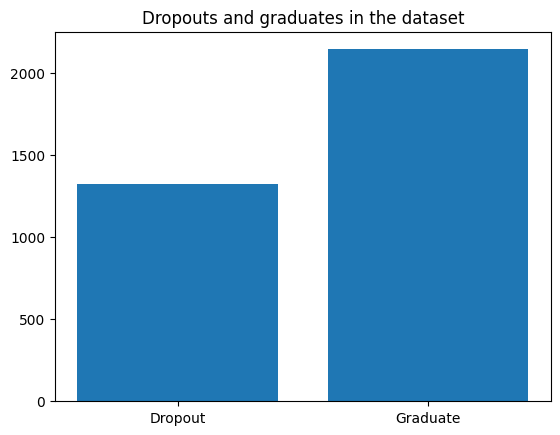

In [320]:
plt.bar(classes,counts)
plt.title("Dropouts and graduates in the dataset")
plt.show()

We also need to drop outliers, only in the columns where the data type is float, and for the column "Age at enrollment"

In [253]:
df.dtypes

Marital status                                      int64
Application mode                                    int64
Application order                                   int64
Course                                              int64
Daytime/evening attendance                          int64
Previous qualification                              int64
Nacionality                                         int64
Mother's qualification                              int64
Father's qualification                              int64
Mother's occupation                                 int64
Father's occupation                                 int64
Displaced                                           int64
Educational special needs                           int64
Debtor                                              int64
Tuition fees up to date                             int64
Gender                                              int64
Scholarship holder                                  int64
Age at enrollm

In [304]:
to_score = list(df.columns[np.where(df.dtypes=="float64")[0]])
to_score.append("Age at enrollment")
to_score

['Curricular units 1st sem (grade)',
 'Curricular units 2nd sem (grade)',
 'Unemployment rate',
 'Inflation rate',
 'GDP',
 'Age at enrollment']

In [306]:
to_score
for col in to_score:
    z = zscore(df[col])
    if any(abs(z)>=3):
        df = df[abs(z)<3]

df.shape

(3468, 35)

We now encode the target labels and generating a training and testing set

In [332]:
X, y = df.drop(["Target"],axis=1), df["Target"]
encoder = LabelEncoder()
y = encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1)

We search for the best parameters

In [310]:
"""xgb_model = xgb.XGBClassifier()
params = {
     "colsample_bytree": uniform(0.7, 0.3),
     "gamma": uniform(0, 3),
     "learning_rate": uniform(0.001, 0.1),
     "max_depth": randint(3, 15),
     "n_estimators": randint(10, 1000),
     "subsample": uniform(0.1, 0.3)
 }

search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=10, n_iter=100, cv=4, verbose=1, n_jobs=1,
                            scoring = "neg_mean_absolute_error",
                            return_train_score=True)

search.fit(X_train, y_train)

best_params = search.best_params_
best_score = search.best_score_

print("Best parameters:",best_params)
print("Best score:",best_score)"""

Fitting 4 folds for each of 100 candidates, totalling 400 fits
Best parameters: {'colsample_bytree': 0.8368913641284352, 'gamma': 2.4783685315282193, 'learning_rate': 0.026137413420705937, 'max_depth': 12, 'n_estimators': 757, 'subsample': 0.37084952809948823}
Best score: -0.08587199185790735


In [311]:
model = xgb.XGBClassifier(objective="binary:logistic",
                          eval_metric=["mae"],
                          learning_rate=0.026,
                          colsample_bytree=0.84,
                          gamma=2.479,
                          subsample=0.37,
                          max_depth=12,
                          n_estimators=757)
model.fit(X_train,y_train,
          eval_set=[(X_train,y_train)],
          verbose=50)

[0]	validation_0-mae:0.46390
[50]	validation_0-mae:0.23334
[100]	validation_0-mae:0.16079
[150]	validation_0-mae:0.13461
[200]	validation_0-mae:0.12377
[250]	validation_0-mae:0.11704
[300]	validation_0-mae:0.11282
[350]	validation_0-mae:0.11058
[400]	validation_0-mae:0.10815
[450]	validation_0-mae:0.10602
[500]	validation_0-mae:0.10448
[550]	validation_0-mae:0.10347
[600]	validation_0-mae:0.10217
[650]	validation_0-mae:0.10115
[700]	validation_0-mae:0.10039
[750]	validation_0-mae:0.09938
[756]	validation_0-mae:0.09941


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.84, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['mae'], feature_types=None,
              gamma=2.479, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.026, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=757, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [308]:
model = xgb.XGBClassifier(objective="binary:logistic",
                          eval_metric=["mae"],
                          learning_rate=0.078,
                          colsample_bytree=0.79,
                          gamma=0.992,
                          subsample=0.215,
                          max_depth=6,
                          n_estimators=795)
model.fit(X_train,y_train,
          eval_set=[(X_train,y_train)],
          verbose=50)

[0]	validation_0-mae:0.44979
[50]	validation_0-mae:0.13869
[100]	validation_0-mae:0.10921
[150]	validation_0-mae:0.09687
[200]	validation_0-mae:0.08671
[250]	validation_0-mae:0.07890
[300]	validation_0-mae:0.07374
[350]	validation_0-mae:0.07018
[400]	validation_0-mae:0.06684
[450]	validation_0-mae:0.06358
[500]	validation_0-mae:0.06150
[550]	validation_0-mae:0.05910
[600]	validation_0-mae:0.05763
[650]	validation_0-mae:0.05611
[700]	validation_0-mae:0.05482
[750]	validation_0-mae:0.05285
[794]	validation_0-mae:0.05210


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.79, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['mae'], feature_types=None,
              gamma=0.992, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.078, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=795, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

We check the accuracy score for the test data

In [381]:
y_pred = model.predict(X_test)
print("Accuracy: {} %".format(round(100*accuracy_score(y_test,y_pred),2)))

Accuracy: 92.8 %


Let's now unencode the labels and visualise the predictions against the true values.

In [334]:
y_pred = encoder.inverse_transform(y_pred)
y_test = encoder.inverse_transform(y_test)
x_pred, c_pred = np.unique(y_pred,return_counts=True)
x_test, c_test = np.unique(y_test,return_counts=True)

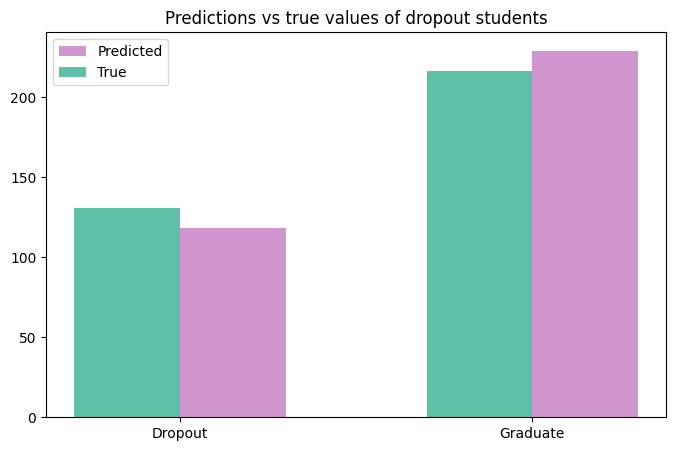

In [373]:
x_axis = np.arange(len(x_pred))
width = 0.3
plt.figure(figsize=(8,5))
plt.bar(x_axis+0.15,c_pred,width=width,label="Predicted",color="#D196D0")
plt.bar(x_axis-0.15,c_test,width=width,label="True",color="#5EC1A7")
plt.xticks(x_axis,classes)
plt.legend()
plt.title("Predictions vs true values of dropout students")
plt.show()